In [1]:
!pip install pyspark findspark nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d39d7a46e5fb8360c61153d33d94812b627878ed52b42a89357c332e9491c2bc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050').set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')\
                  .set('spark.dynamicAllocation.enabled', 'true')\
                  .set('spark.shuffle.service.enabled', 'true') #трекер, чтобы возвращать ресурсы
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

Как проще всего создать RDD? Вызвать метод и передать ему нужный объект

In [ ]:
first_rdd  = sc.parallelize(range(1000000))

In [ ]:
first_rdd.getNumPartitions()

2

А можно ли менять количество партиций? Да, для этого есть два метода: repartition() и coalesce(). Первый используется для увеличения и уменьшения количества партиций, второй только для снижения, прчем coalesce будет работать эффективнее. Много партиций - дольше будет считаться, но если данных много, то обязательно нужно

repartition()` всегда приводит к равномерному перераспределению данных, что ведет к shuffle. Если Вы уменьшаете число партиций, то стоит использовать `coalesce()`, который может избежать shuffle

In [ ]:
first_rdd = first_rdd.repartition(5)
print(first_rdd.getNumPartitions())

5


In [ ]:
first_rdd = first_rdd.repartition(2)
print(first_rdd.getNumPartitions())

2


In [ ]:
first_rdd = first_rdd.coalesce(1)
print(first_rdd.getNumPartitions())

1


In [ ]:
a = %time first_rdd.sum()

CPU times: user 47.9 ms, sys: 7.85 ms, total: 55.7 ms
Wall time: 5.31 s


Посмотрим на время выполнения для разного числа партиций

In [ ]:
result = []
first_rdd  = sc.parallelize(range(5000000))
for partition in range(1, 30):
    first_rdd = first_rdd.repartition(partition)
    time = %timeit -o  -n 1 -r 1 first_rdd.sum()
    time = time.best
    result.append((partition, time))

10.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.96 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.44 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.45 s ± 0 ns per loop (mean ± std. dev. o

In [ ]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

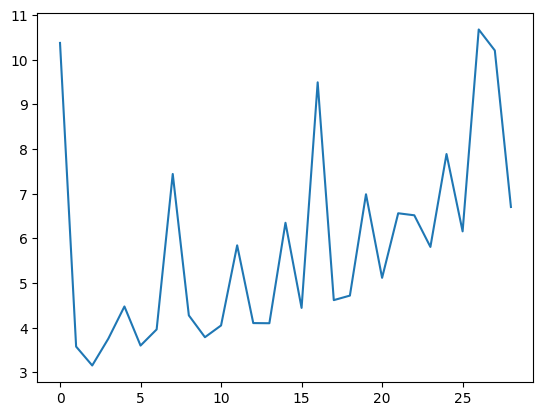

In [ ]:
plt.plot([res[1] for res in result])

А почему лучший результат при небольшом количестве партиций?

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

2

Из list также можно создавать RDD

In [ ]:
bad_list = [1, 2, 3, 'a', 10, 'b']

In [ ]:
bad_list_rdd = sc.parallelize(bad_list)

In [ ]:
bad_list_rdd.collect()

[1, 2, 3, 'a', 10, 'b']

Еще можно создать RDD через textFile и wholeTextFiles

In [ ]:
text_rdd = sc.textFile('/content/drive/My Drive/Colab_Notebooks/PySpark/lesson_2/spark_text.txt')

In [ ]:
text_rdd.take(1)

['Apache Spark is an open-source unified analytics engine for large-scale data processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. Originally developed at the University of California, Berkeley AMPLab, the Spark codebase was later donated to the Apache Software Foundation, which has maintained it since.']

wholeTextFiles создает PairRDD в формате key-value, где ключ - имя файла, а значения - то, что находистя в файле. Имена файлов считываются из папки через wholeTextFiles

In [ ]:
dirPath = 'files'
os.mkdir(dirPath)
with open(os.path.join(dirPath, "1.txt"), "w") as file1:
    _ = file1.write("[1 2 3]")
with open(os.path.join(dirPath, "2.txt"), "w") as file2:
    _ = file2.write("[4 5 6]")
textFiles = sc.wholeTextFiles(dirPath)

In [ ]:
textFiles

org.apache.spark.api.java.JavaPairRDD@700cb94

In [ ]:
textFiles.collect()

[('file:/content/files/1.txt', '[1 2 3]'),
 ('file:/content/files/2.txt', '[4 5 6]')]

У RDD есть стандартно 2 типа методов - actions и transformations

**Actions**

Начнем с actions, то есть того, что заставит посчитать

In [ ]:
first_rdd = first_rdd.coalesce(2)

In [ ]:
first_rdd.sum()

12499997500000

In [ ]:
first_rdd.min(), first_rdd.max()

(0, 4999999)

In [ ]:
first_rdd.first()

1229760

In [ ]:
first_rdd.take(2)

[1229760, 1229761]

In [ ]:
first_rdd.count()

5000000

In [ ]:
a = first_rdd.collect()

In [ ]:
first_rdd.saveAsTextFile, first_rdd.saveAsPickleFile

(<bound method RDD.saveAsTextFile of CoalescedRDD[167] at coalesce at <unknown>:0>,
 <bound method RDD.saveAsPickleFile of CoalescedRDD[167] at coalesce at <unknown>:0>)

In [ ]:
first_rdd.reduce(lambda x, y: x + y)

12499997500000

Если нужно получить небольшое число записей на драйвер и, при этом, сохранить распределение, то лучше сделать выборку

In [ ]:
first_rdd.takeSample(withReplacement=False, num=5, seed=5757)

[4229148, 2006719, 1301632, 4730629, 1025149]

**Transformations**

Это просто трансформации, которые не будут вычисляться до вызова actions

In [ ]:
a = sc.parallelize([1, 2, 3])
b = sc.parallelize([2, 3, 4])

In [ ]:
c = a + b

In [ ]:
c.collect()

[1, 2, 3, 2, 3, 4]

filter

In [ ]:
text_rdd.count()

100

In [ ]:
text_rdd.filter(lambda x: x != '').count()

60

In [ ]:
text_rdd = text_rdd.filter(lambda x: x != '')

map

In [ ]:
stop_words = stopwords.words("english")
stop_words = set(stop_words)

In [ ]:
def mapper_text(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words_with_value = [(word.lower(), 1) for word in words
                        if word not in stop_words]
    return words_with_value

In [ ]:
text_rdd.map(mapper_text).take(1)

[[('apache', 1),
  ('spark', 1),
  ('opensource', 1),
  ('unified', 1),
  ('analytics', 1),
  ('engine', 1),
  ('largescale', 1),
  ('data', 1),
  ('processing', 1),
  ('spark', 1),
  ('provides', 1),
  ('interface', 1),
  ('programming', 1),
  ('entire', 1),
  ('clusters', 1),
  ('implicit', 1),
  ('data', 1),
  ('parallelism', 1),
  ('fault', 1),
  ('tolerance', 1),
  ('originally', 1),
  ('developed', 1),
  ('university', 1),
  ('california', 1),
  ('berkeley', 1),
  ('amplab', 1),
  ('spark', 1),
  ('codebase', 1),
  ('later', 1),
  ('donated', 1),
  ('apache', 1),
  ('software', 1),
  ('foundation', 1),
  ('maintained', 1),
  ('since', 1)]]

flatMap

Попробуем применить map и flatMap

In [ ]:
text_rdd.map(mapper_text).count()

60

In [ ]:
text_rdd.flatMap(mapper_text).count()

1921

Как так?

In [ ]:
text_rdd.map(mapper_text).map(len).sum()

1921

вроде понятно что случилось, но давайте на игрушечном примере

In [ ]:
simple_example = sc.parallelize([[1, 2, 3], [2, 3, 4], [4, 5, 6]])

In [ ]:
def pow_elements(elements):
    return [x**2 for x in elements]

In [ ]:
simple_example.map(pow_elements).collect()

[[1, 4, 9], [4, 9, 16], [16, 25, 36]]

In [ ]:
simple_example.flatMap(pow_elements).collect()

[1, 4, 9, 4, 9, 16, 16, 25, 36]

groupByKey

In [ ]:
text_rdd = text_rdd.flatMap(mapper_text)

In [ ]:
text_rdd.groupByKey().mapValues(len).collect()

[('opensource', 1),
 ('unified', 2),
 ('analytics', 5),
 ('engine', 4),
 ('provides', 10),
 ('programming', 9),
 ('entire', 1),
 ('clusters', 2),
 ('implicit', 1),
 ('fault', 1),
 ('tolerance', 1),
 ('originally', 3),
 ('developed', 2),
 ('university', 1),
 ('codebase', 1),
 ('readonly', 2),
 ('multiset', 1),
 ('items', 2),
 ('faulttolerant', 1),
 ('way2', 1),
 ('api', 14),
 ('in', 7),
 ('primary', 1),
 ('use', 9),
 ('encouraged3', 1),
 ('even', 5),
 ('though', 1),
 ('technology', 2),
 ('2012', 1),
 ('response', 2),
 ('limitations', 1),
 ('forces', 1),
 ('particular', 1),
 ('programs', 3),
 ('read', 1),
 ('input', 2),
 ('disk', 3),
 ('reduce', 3),
 ('results', 2),
 ('store', 1),
 ('working', 1),
 ('set', 5),
 ('offers', 3),
 ('deliberately', 1),
 ('form', 2),
 ('memory8', 1),
 ('facilitates', 1),
 ('iterative', 2),
 ('algorithm', 1),
 ('visit', 1),
 ('multiple', 4),
 ('ie', 1),
 ('databasestyle', 1),
 ('querying', 2),
 ('latency', 2),
 ('may', 2),
 ('several', 1),
 ('orders', 1),
 ('ma

sortByKey

In [ ]:
text_rdd.groupByKey().mapValues(len).sortByKey().collect()

[('10', 1),
 ('11', 1),
 ('16', 1),
 ('1ms', 1),
 ('1x', 1),
 ('20', 1),
 ('2009', 1),
 ('2012', 1),
 ('23', 1),
 ('24', 1),
 ('2x', 3),
 ('50', 1),
 ('5g', 1),
 ('a', 4),
 ('able', 1),
 ('abstraction', 6),
 ('abstracts', 1),
 ('according', 1),
 ('accumulators', 1),
 ('achieved', 1),
 ('across', 5),
 ('acyclic', 1),
 ('added', 2),
 ('addition', 1),
 ('additional', 1),
 ('advantage', 4),
 ('advantages', 1),
 ('afforded', 1),
 ('aggregation', 1),
 ('aggregations', 1),
 ('algorithm', 1),
 ('algorithms', 7),
 ('all', 1),
 ('allocating', 1),
 ('allowing', 3),
 ('allows', 2),
 ('alluxio', 1),
 ('almost', 1),
 ('alone', 1),
 ('alongside', 1),
 ('als', 1),
 ('also', 15),
 ('alternating', 1),
 ('although', 1),
 ('amazon', 3),
 ('among', 2),
 ('amplab', 3),
 ('analysis', 2),
 ('analysts', 1),
 ('analytics', 5),
 ('anonymous', 1),
 ('apache', 56),
 ('apex', 1),
 ('api', 14),
 ('api27', 1),
 ('api67', 1),
 ('apis', 3),
 ('apple', 1),
 ('application', 8),
 ('applications', 5),
 ('applied', 1),
 ('a

И так на самом деле много методов, но предалагаю написать подсчет частоты слов и сделаем это в стиле программ на java

In [ ]:
text_rdd = sc.textFile('/content/drive/My Drive/Colab_Notebooks/PySpark/lesson_2/spark_text.txt')

In [ ]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text)\
                 .groupByKey()\
                 .mapValues(len)\
                 .sortBy(lambda x: x[1], ascending=False)\
                 .collect()

In [ ]:
result[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('learning', 15),
 ('rdd', 15),
 ('also', 15)]

Забыли про reduceByKey

In [ ]:
text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .reduceByKey(lambda x, y: x + y)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('learning', 15),
 ('rdd', 15),
 ('also', 15)]

Стоит заметить, что `groupByKey()` предполагает перемещение всех записей с одним ключом на один экзекьютор. В случае очень скошенных распределений это может привести к падению экзекьютора с OOM. Поэтому всегда при группировках стоит подумать об использовании `reduceByKey()`.

Так, на лекции было что-то про count, который не делает shuffle да и вообще можно проще написать?

In [ ]:
def mapper_text_simple(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words = [word.lower() for word in words
                        if word not in stop_words]
    return words

In [ ]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text_simple)\
                 .countByValue()
result = sorted(result.items(), key=lambda x: x[1], reverse=True)
print(result[:10])

[('spark', 110), ('apache', 56), ('data', 44), ('streaming', 36), ('distributed', 23), ('processing', 19), ('sql', 17), ('rdd', 15), ('learning', 15), ('also', 15)]


Замеры

In [ ]:
%%timeit

text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .groupByKey()\
        .mapValues(len)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

In [ ]:
%%timeit

text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .reduceByKey(lambda x, y: x + y)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

In [ ]:
%%timeit

result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text_simple)\
                 .countByValue()
result = sorted(result.items(), key=lambda x: x[1], reverse=True)[:10]

**Join'ы**

Тут просто на игрушечном примере пощупаем данную операцию

In [ ]:
rdd_a = sc.parallelize([
                        ('a', [1, 2]),
                        ('b', [2, 4])])

rdd_b = sc.parallelize([
                        ('a', [10]),
                        ('c', [11])])

In [ ]:
rdd_a.join(rdd_b).collect()

[('a', ([1, 2], [10]))]

In [ ]:
rdd_a.leftOuterJoin(rdd_b).collect()

[('b', ([2, 4], None)), ('a', ([1, 2], [10]))]

In [ ]:
rdd_a.fullOuterJoin(rdd_b).collect()

[('b', ([2, 4], None)), ('c', (None, [11])), ('a', ([1, 2], [10]))]

**Домашнее задание 1**

Посчитать количество рейтингов больше 4 для каждого фильма и вывести фильмы в порядке убывания количества этих оценок (можно вывести топ 10)

Файл можете взять из прошлого домашнего задания + сохраните результат на диск

In [ ]:
data = sc.textFile('/content/drive/My Drive/Colab_Notebooks/PySpark/user_ratedmovies.dat')
data = data.map(lambda x: (x.split("\t")[1], x.split('\t')[2]))\
           .filter(lambda x: x != ('movieID', 'rating'))

data.take(10)

[('3', '1'),
 ('32', '4.5'),
 ('110', '4'),
 ('160', '2'),
 ('163', '4'),
 ('165', '4.5'),
 ('173', '3.5'),
 ('296', '5'),
 ('353', '3.5'),
 ('420', '2')]

In [ ]:
data = data.filter(lambda x: float(x[1]) > 4)\
           .countByKey()
data = sorted(data.items(), key=lambda x: x[1], reverse=True)

data[:10]

[('2571', 900),
 ('318', 887),
 ('296', 878),
 ('2959', 828),
 ('4993', 756),
 ('7153', 719),
 ('5952', 697),
 ('858', 690),
 ('50', 688),
 ('2858', 680)]

In [ ]:
with open('/content/drive/My Drive/Colab_Notebooks/PySpark/lesson_2/out1.txt', 'w') as f:
    for key, value in data:
		    f.write(f'{key}, {value}\n')

**Домашнее задание 2**

В этом задании у вас есть файл с обученным word2vec на произведении Достоевского Преступление и наказание. Файл - list, каждый элемент которого слово и его вектор в формате ('word', [vector]). Необходимо для каждого слова собрать список его top 10 похожих слов по косинусной метрике
Результат также сохраните на диск и выведите синонимы для слова 'топор' и 'деньга'.
Файл в пикле, так что для считывания воспользуйтесь не spark, можете взять любимый pandas

Файл не очень уж и маленький, рекомендую сначала написать код на кошках/собачках, а потом уже на всем, так как ядра 2, считаться будет очень долго.
В качестве одного из вариантов можете рассмотреть метод cartesian

In [7]:
import pandas as pd

data = pd.read_pickle('/content/drive/My Drive/Colab_Notebooks/PySpark/lesson_2/w2v_vectors.pickle')
data = sc.parallelize(data)
data.take(1)

[('это',
  [0.14321378,
   -0.80575335,
   -0.49581036,
   -0.06394294,
   -1.2238435,
   -0.44410643,
   0.49273458,
   0.17389631,
   -0.27776885,
   0.50880307,
   -0.07283105,
   0.72964376,
   1.1526197,
   0.94315845,
   -1.0720603,
   -0.235505,
   1.2034348,
   -0.3744024,
   -0.36203885,
   -0.07914155,
   0.3772516,
   -0.878622,
   -0.927112,
   0.73365724,
   0.107223585,
   -0.39829564,
   0.61899257,
   0.29151887,
   1.013499,
   0.03111156])]

In [8]:
data = data.cartesian(data)\
           .filter(lambda x: x[0] != x[1])
data.take(1)

[(('это',
   [0.14321378,
    -0.80575335,
    -0.49581036,
    -0.06394294,
    -1.2238435,
    -0.44410643,
    0.49273458,
    0.17389631,
    -0.27776885,
    0.50880307,
    -0.07283105,
    0.72964376,
    1.1526197,
    0.94315845,
    -1.0720603,
    -0.235505,
    1.2034348,
    -0.3744024,
    -0.36203885,
    -0.07914155,
    0.3772516,
    -0.878622,
    -0.927112,
    0.73365724,
    0.107223585,
    -0.39829564,
    0.61899257,
    0.29151887,
    1.013499,
    0.03111156]),
  ('всё',
   [-0.30770057,
    -1.296609,
    -0.7222447,
    -0.20211408,
    -0.7666911,
    -1.0031737,
    -0.26696622,
    -0.0668253,
    0.0026058692,
    -0.105746254,
    0.16301736,
    0.41609567,
    0.6745765,
    1.1453478,
    -0.99610287,
    -0.53095675,
    1.4379495,
    -0.48172295,
    -0.14234278,
    -0.49253845,
    0.28369433,
    -0.6198971,
    -1.158686,
    0.1808683,
    -0.5055639,
    -0.3938737,
    -0.076981455,
    0.6512924,
    1.5167931,
    0.015842797]))]

In [9]:
import numpy as np

def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

data = data.map(lambda x: (x[0][0], {x[1][0]: cos_sim(x[0][1], x[1][1])}))
data.take(1)

[('это', {'всё': 0.8356289267539978})]

In [10]:
data = data.reduceByKey(lambda x, y: dict(x, **y))\
           .mapValues(lambda x: sorted(x.items(), key = lambda x: x[1], reverse = True)[:10])
data.take(1)

[('мера',
  [('предел', 0.8030657768249512),
   ('правило', 0.6602046489715576),
   ('особенно', 0.6598761081695557),
   ('цена', 0.6544543504714966),
   ('ощущение', 0.6365392208099365),
   ('высокий', 0.636443555355072),
   ('неприятный', 0.626589298248291),
   ('солидный', 0.6210660338401794),
   ('некоторый', 0.6208765506744385),
   ('весьма', 0.6163438558578491)])]

In [11]:
data.saveAsTextFile('/content/drive/My Drive/Colab_Notebooks/PySpark/lesson_2/out2')

In [12]:
data.filter(lambda x: x[0] == 'топор' or x[0] == 'деньга').collect()

[('деньга',
  [('вещь', 0.9063147902488708),
   ('отдать', 0.8706483244895935),
   ('убить', 0.8420270085334778),
   ('значит', 0.838628351688385),
   ('известно', 0.8266707062721252),
   ('отец', 0.8146180510520935),
   ('получить', 0.8137906193733215),
   ('ограбить', 0.8044242858886719),
   ('копейка', 0.8012077808380127),
   ('полечка', 0.7804851531982422)]),
 ('топор',
  [('левый', 0.9236524701118469),
   ('старуха', 0.922432005405426),
   ('колено', 0.920665979385376),
   ('побежать', 0.912059485912323),
   ('ломать', 0.910239040851593),
   ('бросить', 0.9063428640365601),
   ('схватить', 0.9024109840393066),
   ('обнять', 0.8999080657958984),
   ('бить', 0.898546040058136),
   ('положить', 0.8972360491752625)])]